In [1]:
import solaris as sol
import os
import cv2
import geopandas as gpd
import numpy as np
from matplotlib import pyplot as plt
from shapely.ops import cascaded_union
from skimage import io

/opt/conda/envs/solaris/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/envs/solaris/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/envs/solaris/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/envs/solaris/lib/python3.7/site-packages/tensorflow/python/framework

# Pick up a sample from train-set and play around with it

In [2]:
data_dir = '/data/spacenet6/spacenet6/train/'

# RGB
rgb_image_dir = os.path.join(data_dir, 'PS-RGB')
rgb_image_filenames = os.listdir(rgb_image_dir)
rgb_image_filenames.sort()

# SAR intensity
sar_image_dir = os.path.join(data_dir, 'SAR-Intensity')
sar_image_filenames = os.listdir(sar_image_dir)
sar_image_filenames.sort()

# building label
building_label_dir = os.path.join(data_dir, 'Buildings')
building_label_filenames = os.listdir(building_label_dir)
building_label_filenames.sort()

# get a path of one sample from the dataset
sample_idx = 300

sar_image_filename = sar_image_filenames[sample_idx]
rgb_image_filename = rgb_image_filenames[sample_idx]
building_label_filename = building_label_filenames[sample_idx]

sar_image_path = os.path.join(sar_image_dir, sar_image_filename)
rgb_image_path = os.path.join(rgb_image_dir, rgb_image_filename)
building_label_path = os.path.join(building_label_dir, building_label_filename)

## Pan-sparpened RGB image

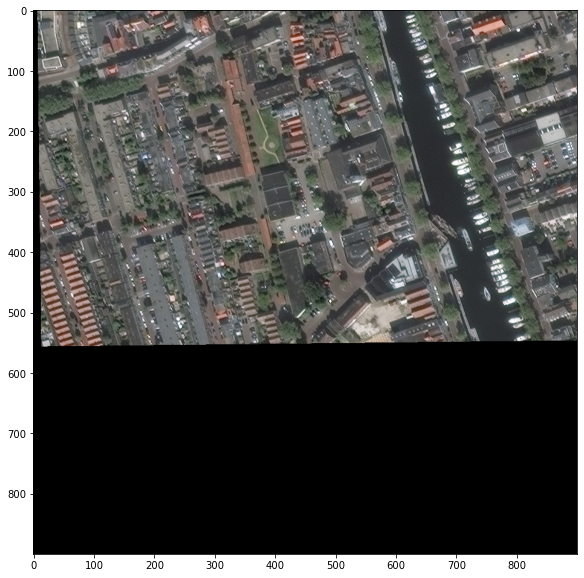

In [3]:
def show_rgb_image(rgb_image, figsize=(10, 10)):
    f, axarr = plt.subplots(figsize=figsize)
    axarr.imshow(rgb_image)

rgb_image = io.imread(rgb_image_path)
show_rgb_image(rgb_image)

## SAR intensity image

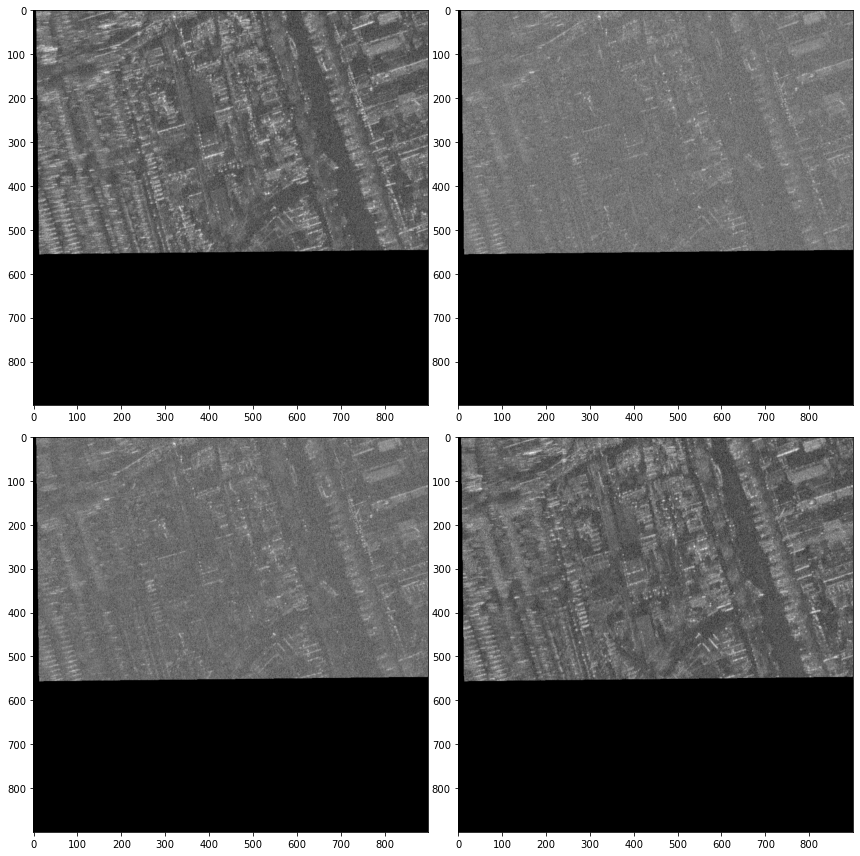

In [4]:
def show_sar_intensity(sar_image, figsize=(12, 12)):
    f, axarr = plt.subplots(2, 2, figsize=figsize)
    axarr[0][0].imshow(sar_image[:, :, 0], cmap='gray')
    axarr[0][1].imshow(sar_image[:, :, 1], cmap='gray')
    axarr[1][0].imshow(sar_image[:, :, 2], cmap='gray')
    axarr[1][1].imshow(sar_image[:, :, 3], cmap='gray')
    f.tight_layout()

sar_image = io.imread(sar_image_path)
show_sar_intensity(sar_image)

## Get valid image region by masking SAR intensiry

In [5]:
def show_mask(masks, figsize=(10, 10)):
    f, axarr = plt.subplots(figsize=figsize)
    axarr.imshow(masks, cmap='gray')

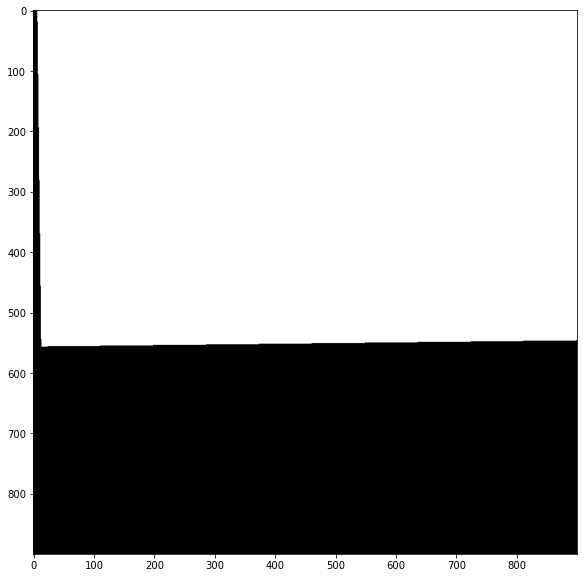

In [6]:
def get_roi_mask(sar_image):
    mask = sar_image.sum(axis=-1) > 0.0
    return mask

roi_mask = get_roi_mask(sar_image)
show_mask(roi_mask)

## Generate building instance mask

In [7]:
instance_mask = sol.vector.mask.instance_mask(
    df=building_label_path,
    reference_im=sar_image_path
)
instance_mask[np.logical_not(roi_mask)] = 0

if instance_mask.ndim == 2:  # if n_building = 1
    instance_mask = instance_mask[:, :, np.newaxis]

print(instance_mask.shape)  # will show (900, 900, n_buildings)

(900, 900, 147)


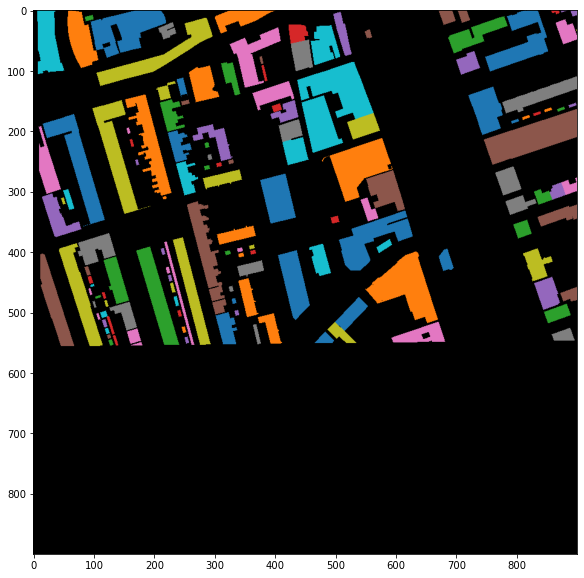

In [8]:
def colorize_instance_mask(instance_mask):
    import seaborn as sns
    def get_palette(n_color):
        sns_palette = sns.color_palette(n_colors=n_color)
        palette = []
        for normalized_rgb in sns_palette:
            rgb = [int(c * 255) for c in normalized_rgb]
            palette.append(rgb)
        return palette
    
    h, w, n_building = instance_mask.shape
    palette = get_palette(n_building)
    
    colorized_mask = np.zeros(shape=[h, w, 3], dtype=np.uint8)
    for i in range(n_building):
        colorized_mask[instance_mask[:, :, i] > 0] = np.array(palette[i])

    return colorized_mask


colorized_mask = colorize_instance_mask(instance_mask)
show_rgb_image(colorized_mask)

## Remove small buildings

In [9]:
def compute_instance_pixel_extents(instance_mask):
    instance_extents = []
    _, _, n_building = instance_mask.shape
    for i in range(n_building):
        extent = (instance_mask[:, :, i] > 0).sum()
        instance_extents.append(extent)
    return instance_extents


def remove_small_building(instance_mask, min_extent):
    instance_extents = compute_instance_pixel_extents(instance_mask)
    return instance_mask[:, :, np.array(instance_extents) > min_extent]


instance_mask = remove_small_building(instance_mask, min_extent=20)
print(instance_mask.shape)  # will show (900, 900, n_buildings)

(900, 900, 143)


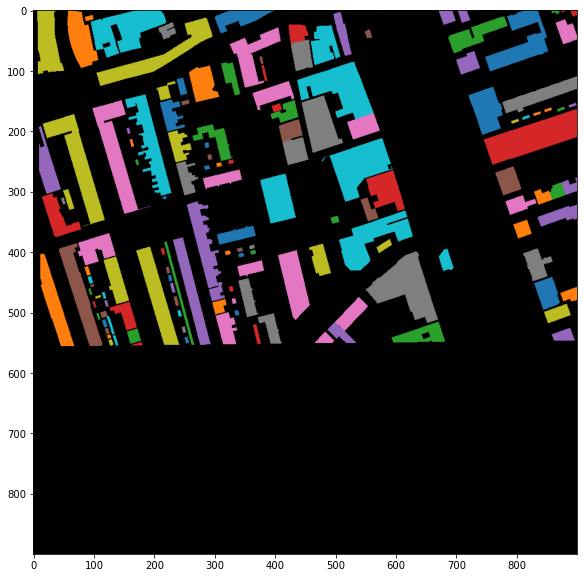

In [10]:
colorized_mask = colorize_instance_mask(instance_mask)
show_rgb_image(colorized_mask)

## Generate building footprint and boundary mask

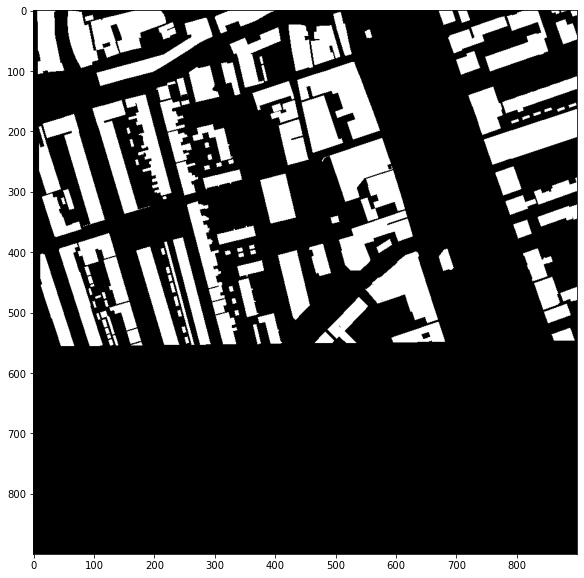

In [11]:
def generate_footprint_mask(instance_mask):
    footprint_mask = (instance_mask.sum(axis=2)) > 0
    footprint_mask = footprint_mask.astype(np.uint8)
    return footprint_mask


footprint_mask = generate_footprint_mask(instance_mask)
show_mask(footprint_mask)

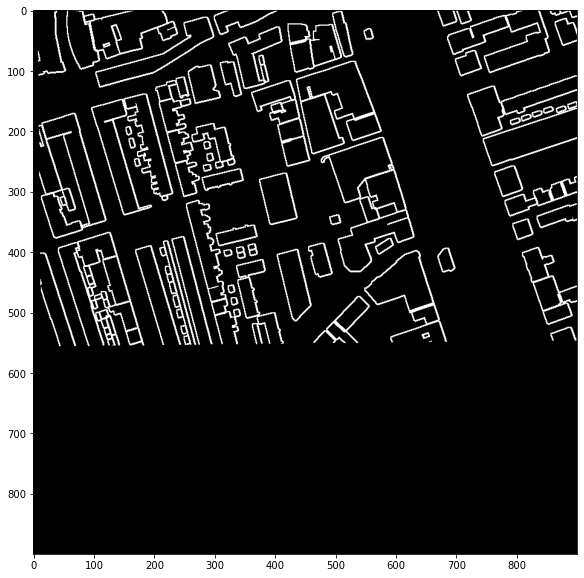

In [12]:
def generate_boundary_mask(instance_mask, boundary_width_pixel):
    kernel = cv2.getStructuringElement(
        cv2.MORPH_ELLIPSE,
        (boundary_width_pixel, boundary_width_pixel)
    )
    h, w, n_building = instance_mask.shape
    boundary_mask = np.zeros(shape=[h, w], dtype=np.uint8)
    
    for i in range(n_building):
        dilated = cv2.dilate(
            instance_mask[:, :, i],
            kernel,
            iterations=1
        )
        boundary = dilated - instance_mask[:, :, i]
        boundary_mask[boundary > 0] = 1
        
    return boundary_mask


boundary_mask = generate_boundary_mask(instance_mask, boundary_width_pixel=6)
boundary_mask[np.logical_not(roi_mask)] = 0
show_mask(boundary_mask)

## Combine footprint and boundary mask

In [13]:
def combine_masks(footprint_mask, boundary_mask):
    combined_mask = np.zeros_like(footprint_mask)
    combined_mask[footprint_mask > 0] = 1
    combined_mask[boundary_mask > 0] = 2
    return combined_mask  # 0: background, 1: building footprint, 2: building boundary


combined_mask = combine_masks(footprint_mask, boundary_mask)

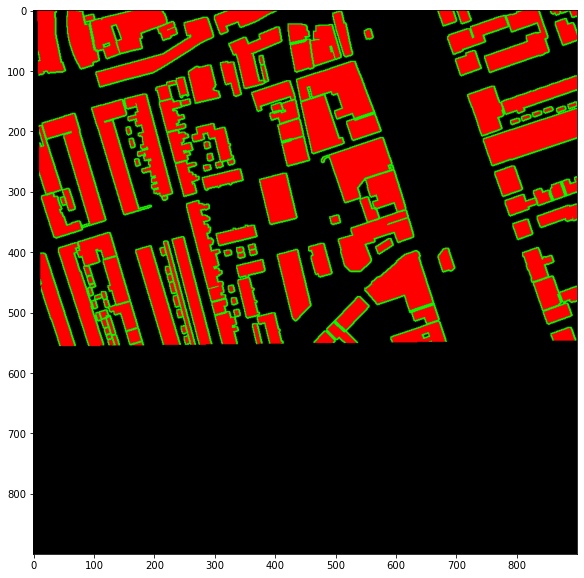

In [14]:
h, w = footprint_mask.shape
combined_mask_color = np.zeros(shape=(h, w, 3), dtype=np.uint8)
combined_mask_color[combined_mask == 1] = np.array([255, 0, 0])  # red for building footprint
combined_mask_color[combined_mask == 2] = np.array([0, 255, 0])  # green for building outer boundary

show_rgb_image(combined_mask_color)

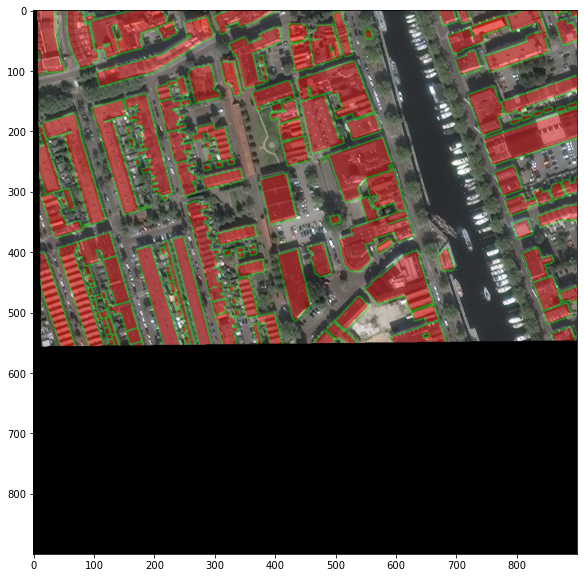

In [15]:
def overlay_mask_on_image(image, mask_color, alpha=0.4):
    ret = image.copy()
    ret[mask_color.sum(axis=-1) > 0] = mask_color[mask_color.sum(axis=-1) > 0]
    ret = cv2.addWeighted(ret, alpha, image, 1 - alpha, 0)
    return ret

rgb_mask_overlayed = overlay_mask_on_image(rgb_image, combined_mask_color)
show_rgb_image(rgb_mask_overlayed)